In [ ]:
!nvidia-smi

Wed Oct 16 11:03:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download video

In [ ]:
SOURCE_VIDEO_PATH = "/content/drive/My Drive/DC 3/7623_classification_video.mp4"

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.8/112.6 GB disk)


## Install Roboflow Supervision

In [ ]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.24.0


## Load pre-trained YOLOv8 model

In [ ]:
MODEL = "/content/drive/My Drive/best.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv10m summary (fused): 369 layers, 16,451,542 parameters, 0 gradients, 63.4 GFLOPs


In [ ]:
class_names = model.names
print("Classes of the model:")
for class_id, class_name in class_names.items():
    print(f"Class ID {class_id}: {class_name}")

Classes of the model:
Class ID 0: 0


## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest
selected_classes = [0]

In [ ]:
import supervision as sv
import numpy as np

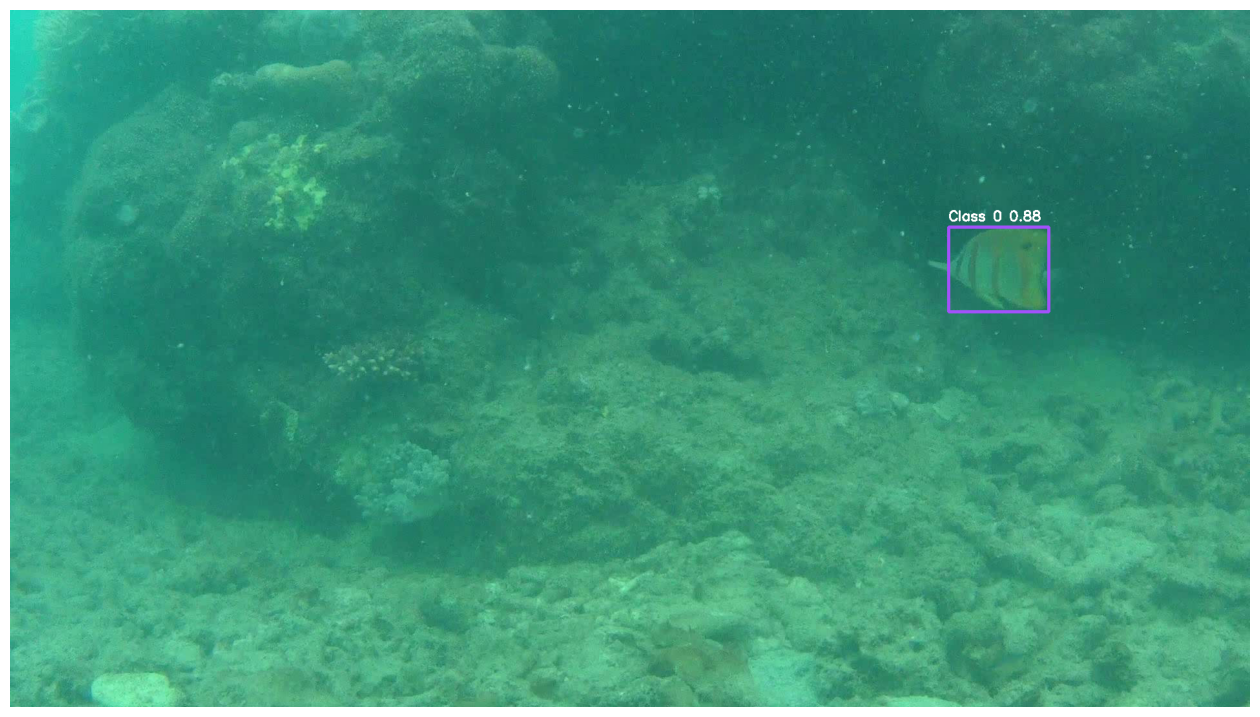

In [ ]:
import cv2

# Create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create instance of BoxAnnotator without labels
box_annotator = sv.BoxAnnotator(thickness=4)

# Acquire first video frame
iterator = iter(generator)
frame = next(iterator)

# Model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# Convert to Detections
detections = sv.Detections.from_ultralytics(results)

# Only consider class ids from selected_classes defined above
selected_classes = [0]  # You only have class 0 (fish)
detections = detections[np.isin(detections.class_id, selected_classes)]

# Annotate frame with bounding boxes
annotated_frame = box_annotator.annotate(scene=frame, detections=detections)

# Add labels to the annotated frame manually using OpenCV
# Iterate over the bounding boxes, confidence, and class IDs to draw labels
for bbox, confidence, class_id in zip(detections.xyxy, detections.confidence, detections.class_id):
    x1, y1, x2, y2 = bbox.astype(int)  # Extract and convert to integers
    label = f"Class {class_id} {confidence:.2f}"  # Create label using class_id and confidence
    # Put label above the bounding box
    cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Display the annotated frame with bounding boxes and labels
%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))



## Predict and annotate whole video

In [ ]:
# settings
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

TARGET_VIDEO_PATH = "/content/drive/My Drive/DC 3/7623_classification_video-out.mp4"

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

Exception: Could not open video at /content/drive/My Drive/DC 3/7623_classification_video.mp4

In [ ]:
import cv2
import numpy as np

# Create BYTETracker instance with corrected arguments
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.6,
    lost_track_buffer=60,
    minimum_matching_threshold=0.9,
    frame_rate=10,
    minimum_consecutive_frames=3
)

# Create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create LineZone instance
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)

# Create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Create LineZoneAnnotator instance
line_zone_annotator = sv.LineZoneAnnotator(thickness=4)

# Define callback function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Only consider class id from selected_classes defined above
    detections = detections[np.isin(detections.class_id, selected_classes)]

    # Tracking detections using BYTETracker
    detections = byte_tracker.update_with_detections(detections)

    # Prepare labels for tracked objects
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    # Annotate frame with traces
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )

    # Annotate frame with bounding boxes without labels
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=detections
    )

    # Add labels to the annotated frame manually using OpenCV
    for bbox, label in zip(detections.xyxy, labels):
        x1, y1, x2, y2 = bbox.astype(int)
        # Put label above the bounding box
        cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Update line zone counter
    line_zone.trigger(detections)

    # Annotate frame with line zone information using line_counter
    annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

    return annotated_frame

# Process the entire video with the callback function
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)


In [ ]:
import cv2
import numpy as np

video_list =[7117, 7268, 7393, 7398, 7426, 7434, 7463, 7482, 7490, 7585, 7623, 9852, 9862, 9866, 9870, 9892, 9894, 9898, 9907, 9908]

for video in video_list:

  SOURCE_VIDEO_PATH = f"/content/drive/My Drive/DC 3/raw_videos/{video}_classification_video.mp4"
  # settings
  LINE_START = sv.Point(50, 1500)
  LINE_END = sv.Point(3840-50, 1500)

  TARGET_VIDEO_PATH = f"/content/drive/My Drive/DC 3/predict_videos/{video}_classification_video-out.mp4"


  # Create BYTETracker instance with corrected arguments
  byte_tracker = sv.ByteTrack(
      track_activation_threshold=0.6,
      lost_track_buffer=60,
      minimum_matching_threshold=0.9,
      frame_rate=10,
      minimum_consecutive_frames=3
  )

  # Create VideoInfo instance
  video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

  # Create frame generator
  generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

  # Create LineZone instance
  line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

  # Create instance of BoxAnnotator
  box_annotator = sv.BoxAnnotator(thickness=4)

  # Create instance of TraceAnnotator
  trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

  # Create LineZoneAnnotator instance
  line_zone_annotator = sv.LineZoneAnnotator(thickness=4)

  # Define callback function to be used in video processing
  def callback(frame: np.ndarray, index: int) -> np.ndarray:
      # Model prediction on single frame and conversion to supervision Detections
      results = model(frame, verbose=False)[0]
      detections = sv.Detections.from_ultralytics(results)

      # Only consider class id from selected_classes defined above
      detections = detections[np.isin(detections.class_id, selected_classes)]

      # Tracking detections using BYTETracker
      detections = byte_tracker.update_with_detections(detections)

      # Prepare labels for tracked objects
      labels = [
          f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
          for confidence, class_id, tracker_id
          in zip(detections.confidence, detections.class_id, detections.tracker_id)
      ]

      # Annotate frame with traces
      annotated_frame = trace_annotator.annotate(
          scene=frame.copy(),
          detections=detections
      )

      # Annotate frame with bounding boxes without labels
      annotated_frame = box_annotator.annotate(
          scene=annotated_frame,
          detections=detections
      )

      # Add labels to the annotated frame manually using OpenCV
      for bbox, label in zip(detections.xyxy, labels):
          x1, y1, x2, y2 = bbox.astype(int)
          # Put label above the bounding box
          cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

      # Update line zone counter
      line_zone.trigger(detections)

      # Annotate frame with line zone information using line_counter
      annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

      return annotated_frame

  # Process the entire video with the callback function
  sv.process_video(
      source_path=SOURCE_VIDEO_PATH,
      target_path=TARGET_VIDEO_PATH,
      callback=callback
  )

In [ ]:
import cv2
import numpy as np

# Assuming a list of videos
video_list = [7117, 7268, 7393, 7398, 7426, 7434, 7463, 7482, 7490, 7585, 7623, 9852, 9862, 9866, 9870, 9892, 9894, 9898, 9907, 9908]

for video in video_list:

    SOURCE_VIDEO_PATH = f"/content/drive/My Drive/DC 3/raw_videos/{video}_classification_video.mp4"
    TARGET_VIDEO_PATH = f"/content/drive/My Drive/DC 3/predict_videos/{video}_classification_video-out.mp4"

    # Settings for the line zone
    LINE_START = sv.Point(50, 1500)
    LINE_END = sv.Point(3840 - 50, 1500)

    # **Recreate the YOLOv8 model and BYTETracker for each video** to reset tracking and detection states
    model = YOLO(MODEL)  # Reinitialize YOLOv8 model for each video

    byte_tracker = sv.ByteTrack(
        track_activation_threshold=0.6,
        lost_track_buffer=60,
        minimum_matching_threshold=0.9,
        frame_rate=10,
        minimum_consecutive_frames=3
    )

    # Create VideoInfo instance
    video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

    # Create frame generator
    generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

    # Create LineZone instance (reset for each video)
    line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

    # Create instance of BoxAnnotator
    box_annotator = sv.BoxAnnotator(thickness=4)

    # Create instance of TraceAnnotator
    trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

    # Create LineZoneAnnotator instance
    line_zone_annotator = sv.LineZoneAnnotator(thickness=4)

    # Define callback function to be used in video processing
    def callback(frame: np.ndarray, index: int) -> np.ndarray:
        # Model prediction on single frame and conversion to supervision Detections
        results = model(frame, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results)

        # Only consider class id from selected_classes defined above
        detections = detections[np.isin(detections.class_id, selected_classes)]

        # Reset the tracker for each video by re-creating it
        detections = byte_tracker.update_with_detections(detections)

        # Prepare labels for tracked objects
        labels = [
            f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
            for confidence, class_id, tracker_id
            in zip(detections.confidence, detections.class_id, detections.tracker_id)
        ]

        # Annotate frame with traces
        annotated_frame = trace_annotator.annotate(
            scene=frame.copy(),
            detections=detections
        )

        # Annotate frame with bounding boxes without labels
        annotated_frame = box_annotator.annotate(
            scene=annotated_frame,
            detections=detections
        )

        # Add labels to the annotated frame manually using OpenCV
        for bbox, label in zip(detections.xyxy, labels):
            x1, y1, x2, y2 = bbox.astype(int)
            # Put label above the bounding box
            cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # Update line zone counter
        line_zone.trigger(detections)

        # Annotate frame with line zone information using line_counter
        annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

        return annotated_frame

    # Process the entire video with the callback function
    sv.process_video(
        source_path=SOURCE_VIDEO_PATH,
        target_path=TARGET_VIDEO_PATH,
        callback=callback
    )

KeyboardInterrupt: 